### Looking at potential explanation of place cell remapping. Focus on 1D at first to make things simpler

In [139]:
%matplotlib inline
import nengo
import numpy as np
from spatial_semantic_pointers.utils import encode_point, make_good_unitary, get_axes, \
    generate_region_vector, get_heatmap_vectors, power, make_fixed_dim_periodic_axis, make_optimal_periodic_axis
from spatial_semantic_pointers.plots import SpatialHeatmap
from ssp_navigation.utils.encodings import hilbert_2d
import matplotlib.pyplot as plt

def plot_1d_sim_map(X1, X2, limit, res, vmin=.33):
    """
    Generate plot based on two different axis vectors representing the same space
    """
    
#     xs = np.linspace(-limit, limit, res)
    xs = np.linspace(0, limit, res)
    
    sim = np.zeros((res, res))
    
    for i, x in enumerate(xs):
        for j, y in enumerate(xs):
            sim[i, j] = np.dot(power(X1, x).v, power(X2, y).v)
            
    plt.imshow(sim, vmin=vmin, vmax=1)
    

def plot_1d_data_sim_map(d1, d2, xs, vmin=.33):
    """
    Generate plot based on vector data. Shows the similarity of the two data streams based on space
    """
    
    sim = np.zeros((len(xs), len(xs)))
    
    for i, x in enumerate(xs):
        for j, y in enumerate(xs):
            sim[i, j] = np.dot(d1[i, :], d2[j, :])
            
    plt.imshow(sim, vmin=vmin, vmax=1)

In [59]:
seed = 13
dim = 128#32
limit = 5
res = 32
rng = np.random.RandomState(seed=seed)
X1 = make_good_unitary(dim, rng=rng)
X2 = make_good_unitary(dim, rng=rng)

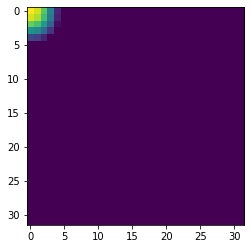

In [60]:
plot_1d_sim_map(X1, X2, limit, res)

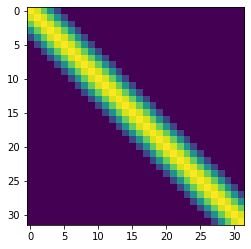

In [61]:
plot_1d_sim_map(X1, X1, limit, res)

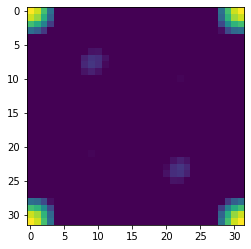

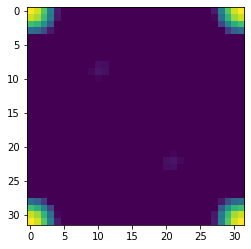

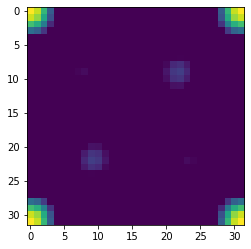

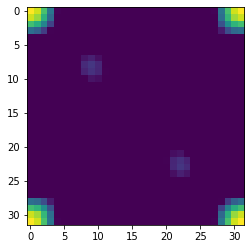

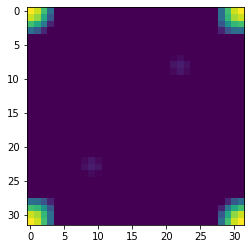

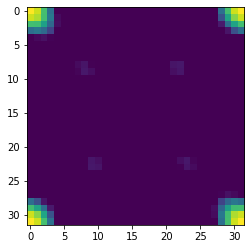

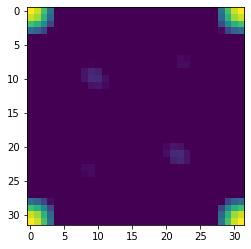

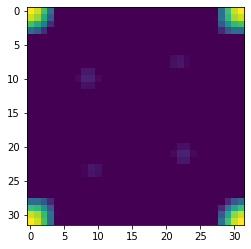

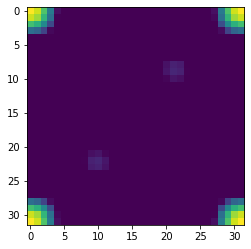

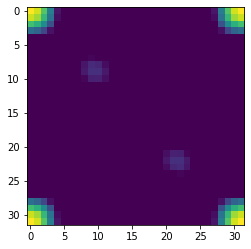

In [65]:
rng = np.random.RandomState(seed=seed)
# X1 = make_good_unitary(dim, rng=rng)
X1 = nengo.spa.SemanticPointer(data=make_fixed_dim_periodic_axis(dim, period=5, rng=rng))
for i in range(10):
    rstate = np.random.RandomState(seed=i)
#     Xn = make_good_unitary(dim, rng=rstate)
    Xn = nengo.spa.SemanticPointer(data=make_fixed_dim_periodic_axis(dim, period=5, rng=rstate))
    plt.figure()
    plot_1d_sim_map(X1, Xn, limit, res)

### Testing with each point convolved with a vector representing the 'visual field'. Visual field will be approximated by an SSP where the metrix is something like 'colour' instead of space. It will vary with space, but as some function (e.g. sine wave) of the space rather than directly correlated.

In [163]:
# some arbitrary smooth functions of space
# room_signals = [
#     lambda s: np.sin(s)+4,
#     lambda s: np.sin(2*s) + np.sin(s + 2)+5,
#     lambda s: np.sin(3*s + 4) + np.sin(s/10. - 2) + 0.3*np.sin(s)+6
# ]

# room_signals = [
#     lambda s: np.sin(s*6)+4,
#     lambda s: np.sin(2*s*5) + np.sin(s + 2)+5,
#     lambda s: np.sin(3*s*4 + 4) + np.sin(s/10. - 2) + 0.3*np.sin(s*3)+6
# ]

rs_rng = np.random.RandomState(seed=13)

def random_signal(s, seed, n_waves=10):
    rng = np.random.RandomState(seed=seed)
    ret = s * 0
    for w in range(n_waves):
        ret += np.sin(s*rng.uniform(-5, 5) + rng.uniform(-5, 5))*rng.uniform(-5, 5) + rng.uniform(-5, 5)
    return ret

room_signals = [
    lambda s: random_signal(s, seed=0, n_waves=10),
    lambda s: random_signal(s, seed=1, n_waves=10),
    lambda s: random_signal(s, seed=2, n_waves=10),
]

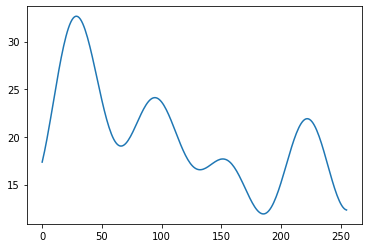

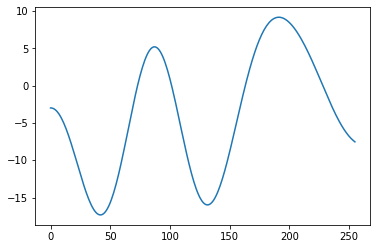

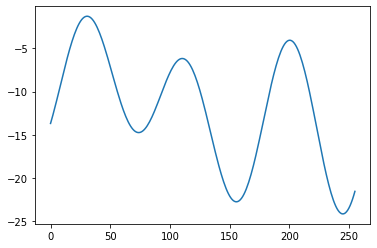

In [168]:
# view these signals
res = 256
limit = 5
xs = np.linspace(0, limit, res)
for signal in room_signals:
    plt.figure()
    plt.plot(signal(xs))

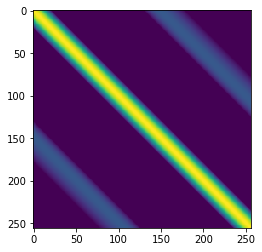

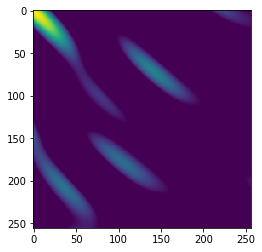

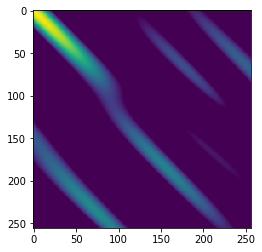

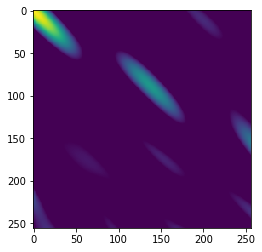

In [181]:
seed = 13
dim = 16#64#128
rng = np.random.RandomState(seed=seed)
# positional SSP
X = make_good_unitary(dim, rng=rng)
# Xs = [
#     make_good_unitary(dim, rng=rng),
#     make_good_unitary(dim, rng=rng),
#     make_good_unitary(dim, rng=rng),
# ]
X = make_optimal_periodic_axis(dim, rng=rng)
Xs = [
    make_optimal_periodic_axis(dim, rng=rng),
    make_optimal_periodic_axis(dim, rng=rng),
    make_optimal_periodic_axis(dim, rng=rng),
]
# feature SSPs
F = make_good_unitary(dim, rng=rng)
F = make_optimal_periodic_axis(dim, rng=rng)
Fs = [
    make_good_unitary(dim, rng=rng),
    make_good_unitary(dim, rng=rng),
    make_good_unitary(dim, rng=rng),
]
Fs = [
    make_optimal_periodic_axis(dim, rng=rng),
    make_optimal_periodic_axis(dim, rng=rng),
    make_optimal_periodic_axis(dim, rng=rng),
]

vecs = np.zeros((len(room_signals), res, dim))

for i, signal in enumerate(room_signals):
    for j, x in enumerate(xs):
#         vecs[i, j, :] = (power(X, x) * power(Fs[i], signal(x))).v
#         vecs[i, j, :] = (power(X, x) * power(F, signal(x))).v
#         vecs[i, j, :] = (power(X, x) * power(F, signal(x))).v
        vecs[i, j, :] = (power(X, x) * power(Fs[i], x)).v

plt.figure()
plot_1d_data_sim_map(vecs[0, :, :], vecs[0, :, :], xs, vmin=.33)
plt.figure()
plot_1d_data_sim_map(vecs[0, :, :], vecs[1, :, :], xs, vmin=.33)
plt.figure()
plot_1d_data_sim_map(vecs[0, :, :], vecs[2, :, :], xs, vmin=.33)
plt.figure()
plot_1d_data_sim_map(vecs[1, :, :], vecs[2, :, :], xs, vmin=.33)

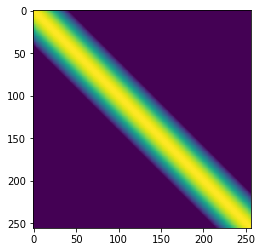

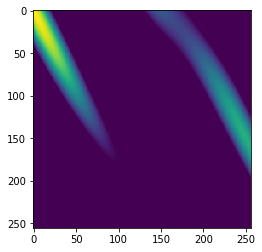

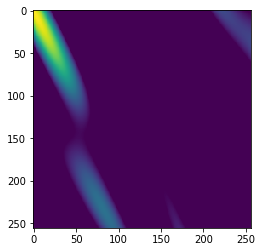

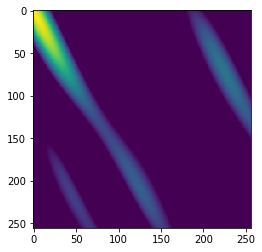

In [182]:
baseline = np.zeros((len(xs), dim))
for j, x in enumerate(xs):
    baseline[j, :] = power(X, x).v

plt.figure()
plot_1d_data_sim_map(baseline, baseline, xs, vmin=.33)    
plt.figure()
plot_1d_data_sim_map(baseline, vecs[0, :, :], xs, vmin=.33)
plt.figure()
plot_1d_data_sim_map(baseline, vecs[1, :, :], xs, vmin=.33)
plt.figure()
plot_1d_data_sim_map(baseline, vecs[2, :, :], xs, vmin=.33)

### using a big offset as well as different SSPs

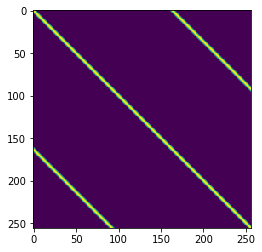

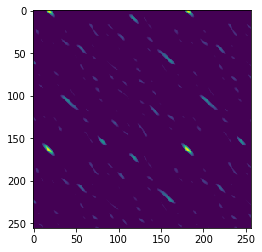

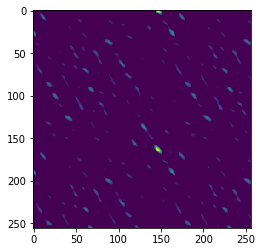

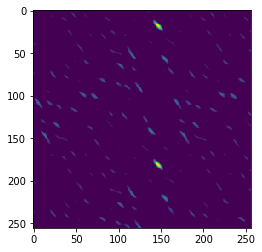

In [160]:
seed = 13
dim = 32#64#128
xs = np.linspace(0, 50, 256)
rng = np.random.RandomState(seed=seed)
# positional SSP
X = make_good_unitary(dim, rng=rng)
# Xs = [
#     make_good_unitary(dim, rng=rng),
#     make_good_unitary(dim, rng=rng),
#     make_good_unitary(dim, rng=rng),
# ]
Xs = [
    make_optimal_periodic_axis(dim, rng=rng),
    make_optimal_periodic_axis(dim, rng=rng),
    make_optimal_periodic_axis(dim, rng=rng),
]

offsets = [
    0,
    124.5,
    6435.3,
]

vecs = np.zeros((len(room_signals), res, dim))

for i, signal in enumerate(room_signals):
    for j, x in enumerate(xs):
        vecs[i, j, :] = power(Xs[i], x + offsets[i]).v

vmin = 0.33
plt.figure()
plot_1d_data_sim_map(vecs[0, :, :], vecs[0, :, :], xs, vmin=vmin)
plt.figure()
plot_1d_data_sim_map(vecs[0, :, :], vecs[1, :, :], xs, vmin=vmin)
plt.figure()
plot_1d_data_sim_map(vecs[0, :, :], vecs[2, :, :], xs, vmin=vmin)
plt.figure()
plot_1d_data_sim_map(vecs[1, :, :], vecs[2, :, :], xs, vmin=vmin)

### testing when always bound with a varying item